## Check where this runs
***

In [3]:
import os
os.environ["our_new"] = ""
envs = os.getenv("LOGNAME")
print(envs)
assert envs == "hughharford"
# if you get an error here, the notebook is not running in HSTH's expected place, and adjusts will be required.
print(os.environ)
if envs == "hughharford":
    environment_running = 'laptop'
else:
    environment_running = 0

hughharford
environ({'BUNDLER_EDITOR': 'code', 'CHROME_DESKTOP': 'code-url-handler.desktop', 'COLORTERM': 'truecolor', 'DBUS_SESSION_BUS_ADDRESS': 'unix:path=/run/user/1000/bus', 'DESKTOP_SESSION': 'ubuntu', 'DISPLAY': ':0', 'EDITOR': 'code', 'ELECTRON_NO_ATTACH_CONSOLE': '1', 'GDK_BACKEND': 'x11', 'GDMSESSION': 'ubuntu', 'GNOME_DESKTOP_SESSION_ID': 'this-is-deprecated', 'GNOME_SETUP_DISPLAY': ':1', 'GNOME_SHELL_SESSION_MODE': 'ubuntu', 'GNOME_TERMINAL_SCREEN': '/org/gnome/Terminal/screen/2ffbd9f5_9c58_49f8_869d_5fe1e8e07518', 'GNOME_TERMINAL_SERVICE': ':1.100', 'GTK_MODULES': 'gail:atk-bridge', 'HOME': '/home/hughharford', 'HOMEBREW_NO_ANALYTICS': '1', 'LANG': 'en_US.UTF-8', 'LANGUAGE': 'en_GB:en', 'LC_ALL': 'en_US.UTF-8', 'LESS': '-R', 'LOGNAME': 'hughharford', 'LSCOLORS': 'Gxfxcxdxbxegedabagacad', 'LS_COLORS': 'rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=01;31:*

# IMPORTS
***

In [4]:
import os
import time
            # data sourcing:
import csv
            # databases:
import sqlite3
            # useful other
from collections import defaultdict
            # data toolkit:
import numpy as np
import pandas as pd
import dask.dataframe as dd
            # plotting
import matplotlib.pyplot as plt
%matplotlib inline  

if not environment_running == 'laptop':
    %pip install seaborn
    # no seaborn by default in AWS SageMaker.
    
import seaborn as sns

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
 # Visualizing Pipelines in HTML
from sklearn import set_config; set_config(display='diagram')

## Establish paths

In [6]:
# check raw data archive path extant:
atp_data_path = os.path.join('..','raw_data','archive')
assert os.path.exists(atp_data_path)

# set read_data path for chunking later on:
read_data_path = os.path.join('..','raw_data','read_data')
assert os.path.exists(read_data_path) 

# check initial data file expected are extant:
matches_data_path_full = os.path.join(atp_data_path, 'all_matches.csv')
assert os.path.exists(matches_data_path_full)

# Show getting 50k rows works:

In [7]:
# this works to convert dates as reading in. good news
schema = {'start_date': 'datetime64[ns]', 'end_date': 'datetime64[ns]'}
matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None).astype(schema)

/tmp/ipykernel_50958/2131584680.py:3: DtypeWarning: Columns (8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None).astype(schema)


In [8]:
matches_df_1st_50k.dtypes.head()
# this confirms astype(schema) works, so date manipulation is available

start_date       datetime64[ns]
end_date         datetime64[ns]
location                 object
court_surface            object
prize_money             float64
dtype: object

In [9]:
matches_df_1st_50k.columns

Index(['start_date', 'end_date', 'location', 'court_surface', 'prize_money',
       'currency', 'year', 'player_id', 'player_name', 'opponent_id',
       'opponent_name', 'tournament', 'round', 'num_sets', 'sets_won',
       'games_won', 'games_against', 'tiebreaks_won', 'tiebreaks_total',
       'serve_rating', 'aces', 'double_faults', 'first_serve_made',
       'first_serve_attempted', 'first_serve_points_made',
       'first_serve_points_attempted', 'second_serve_points_made',
       'second_serve_points_attempted', 'break_points_saved',
       'break_points_against', 'service_games_won', 'return_rating',
       'first_serve_return_points_made', 'first_serve_return_points_attempted',
       'second_serve_return_points_made',
       'second_serve_return_points_attempted', 'break_points_made',
       'break_points_attempted', 'return_games_played', 'service_points_won',
       'service_points_attempted', 'return_points_won',
       'return_points_attempted', 'total_points_won', 'total

# Split by whether winner or loser row
***


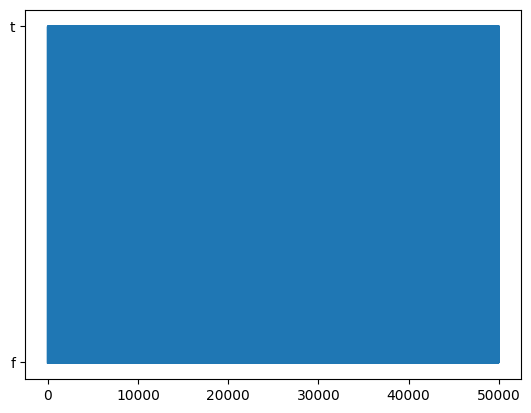

In [13]:

plt.plot(matches_df_1st_50k.player_victory);

# Column dicts

In [14]:
# keep a simple dict of columns to see how full they are/keep track of anything else that seems relevant
check_completeness = {'start_date': 0, 'end_date': 0, 'player_name': 0, 'duration': 0
                      }
check_key_distinguishing_columns = {'doubles': 0, 'masters': 0, 'nation': 0
                                    , 'seed': 0, 'prize_money': 0,
                                    }
check_numerical_columns = {'prize_money': 0,'sets_won': 0,'games_won': 0, 'games_against': 0, 
                    'tiebreaks_won': 0,  'tiebreaks_total': 0, 'serve_rating': 0, 'aces': 0, 
                    'double_faults': 0, 'first_serve_made': 0, 'first_serve_attempted': 0, 
                    'first_serve_points_made': 0, 'first_serve_points_attempted': 0, 'second_serve_points_made': 0, 
                    'second_serve_points_attempted': 0, 'break_points_saved': 0, 'break_points_against': 0, 
                    'service_games_won': 0, 'return_rating': 0, 'first_serve_return_points_made': 0, 
                    'first_serve_return_points_attempted': 0, 'second_serve_return_points_made': 0, 
                    'second_serve_return_points_attempted': 0, 'break_points_made': 0, 
                    'break_points_attempted': 0, 'return_games_played': 0, 'service_points_won': 0, 
                    'service_points_attempted': 0, 'return_points_won': 0, 'return_points_attempted': 0, 
                    'total_points_won': 0, 'total_points': 0, 'duration': 0, 'round_num': 0
                            }
check_mixed_columns = {'seed': 0, 'currency': 0, 'player_name': 0, 'opponent_name': 0, 'duration': 0
                       }
check_boolean_columns = {'player_victory': 0, 'retirement': 0, 'won_first_set': 0
                         }


In [ ]:
# queries
single_date_query = {"start_date > 2010": 0}
single_year_query = {"year > 2010": 0}

### Boolean transformer, can apply to many columns

In [18]:

boolean_transformer = Pipeline([
    ('fill_empties', SimpleImputer(strategy='constant', missing_values=np.nan, fill_value="empty")),
    ('impute_t_is_true', SimpleImputer(strategy='constant', missing_values="t", fill_value=True)),
    ('impute_f_is_false', SimpleImputer(strategy='constant', missing_values="f", fill_value=False)),
])

In [21]:
# Create preprocessor with transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('bools', boolean_transformer, list(check_boolean_columns.keys())), # [or just list of column names] # custom_date_column_selector()
    ],remainder='passthrough'
    )

In [22]:
preprocessor # check preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('bools',
                                 Pipeline(steps=[('fill_empties',
                                                  SimpleImputer(fill_value='empty',
                                                                strategy='constant')),
                                                 ('impute_t_is_true',
                                                  SimpleImputer(fill_value=True,
                                                                missing_values='t',
                                                                strategy='constant')),
                                                 ('impute_f_is_false',
                                                  SimpleImputer(fill_value=False,
                                                                missing_values='f',
                                                                strategy='constant'))]),
                                 ['player_victory', 'retirement',
                                  'won_first_set'])])

# Pipeline

In [ ]:
# Build the pipeline with the different steps
pipeline = Pipeline([
    ('preprocessor', preprocessor),
])